In [2]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sklearn.linear_model as skl
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn import linear_model
import random as rd
from sklearn.utils import resample

/tmp/ipykernel_8472/2848352438.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


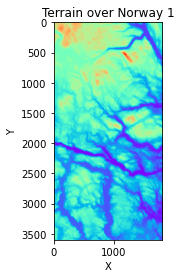

In [3]:
np.random.seed(1509)

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

/tmp/ipykernel_8472/1667005674.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


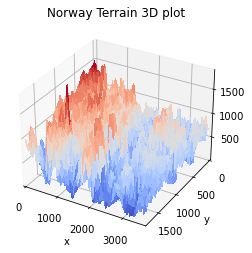

In [4]:
rows, cols = terrain1.shape

fig = plt.figure()
ax = fig.gca(projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

# Plot the surface.
surf = ax.plot_surface(x.T, y.T, terrain1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim(0,rows)
ax.set_ylim(cols, 0)

plt.title("Norway Terrain 3D plot")
plt.show()

(2000, 2)


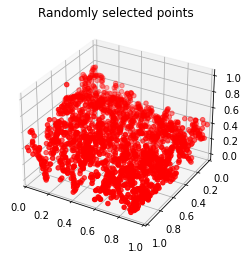

In [5]:
def min_max_scaler(data):
    """
    Perform Min-Max scaling on a given dataset.

    Min-Max scaling rescales the values in the input array 'X' to a given range
    .
    Parameters:
    x (np.array): The input dataset to be scaled.

    Returns:
    scaled(np.array): The scaled dataset with values in the range [0, 1].
    """
    min_i = min(data)
    max_i = max(data)
    
    scaled = (data-min_i)/(max_i-min_i)
    return scaled

def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

#Select n amount of data points to shorten running time
n = 2000

datapoints = np.zeros([n, 2])
z = np.zeros([n, 1])

datapoints = np.column_stack((np.random.randint(0, rows, size = n), np.random.randint(0, cols, size = n)))
print(datapoints.shape)
for i in range(n):
    z[i] = terrain1[int(datapoints[i, 0])][int(datapoints[i, 1])]

z = min_max_scaler(z)
datapoints = np.column_stack((min_max_scaler(datapoints[:,0]), min_max_scaler(datapoints[:,1])))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

scatter = ax.scatter(datapoints[:, 0], datapoints[:, 1], z, c='r', marker='o', label='Selected Points')
plt.title("Randomly selected points")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.show()


In [32]:
def c_tilde(deg, x):
    """
    Generate a subset of features from the input data matrix 'x' up to a specified degree 'deg',
    to use in predicting MSE and R2 score.

    Parameters:
    deg (int): The desired degree up to which features should be generated.
    x (np.array): The input data matrix containing one or more columns of features.

    Returns:
    c (int): The number of features generated up to degree 'i'.
    tilde (np.array): calculated tilde value of input
    """
    c = int((deg + 2) * (deg + 1) / 2)
    tilde = x[:,0:c-1]
    return c, tilde

PolynomialDegree = 20

#create design matrix X
X = create_X(datapoints[:, 0], datapoints[:, 1], PolynomialDegree)

#Remove intercept
X = X[:, 1:]

#Split into train and test sets
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

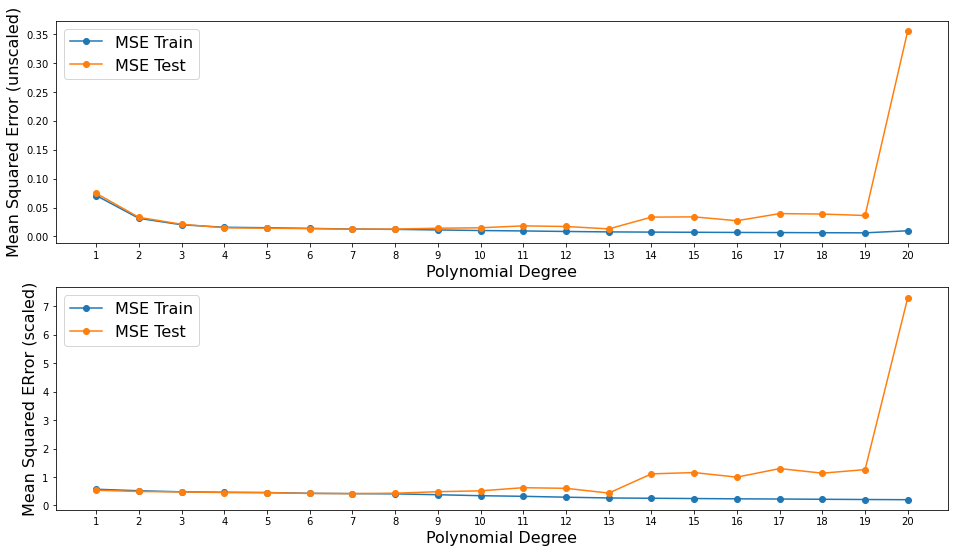

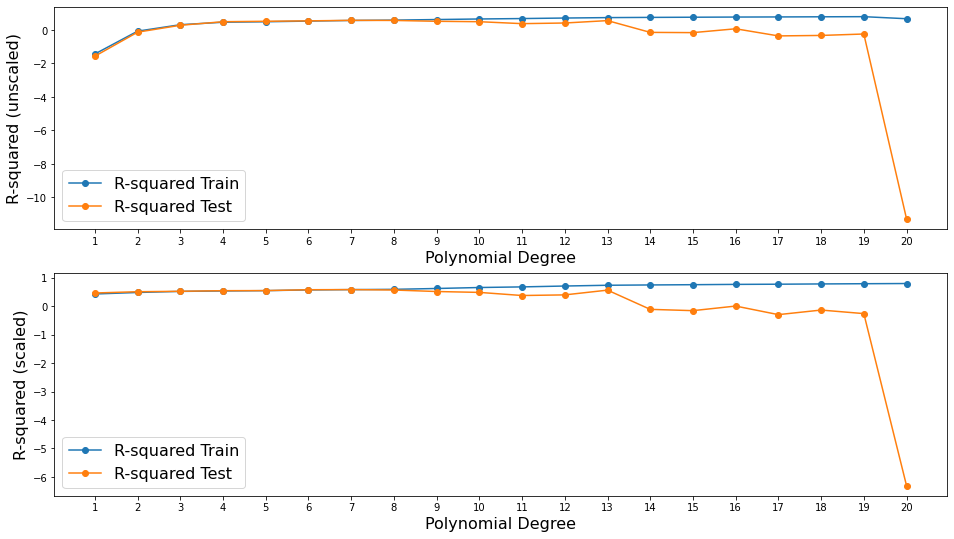

In [33]:
##OLS

np.random.seed(1509)

MSETrain = np.zeros(PolynomialDegree)
MSETest = np.zeros(PolynomialDegree)
MSEScaledTrain = np.zeros(PolynomialDegree)
MSEScaledTest = np.zeros(PolynomialDegree)
R2Train = np.zeros(PolynomialDegree)
R2Test = np.zeros(PolynomialDegree)
R2ScaledTrain = np.zeros(PolynomialDegree)
R2ScaledTest = np.zeros(PolynomialDegree)

for degree in range(1, PolynomialDegree + 1):
    model = LinearRegression(fit_intercept=False)

    # Unscaled Data
    c, Xtilde = c_tilde(degree, x_train)
    model.fit(Xtilde, z_train)
    ztilde = model.predict(Xtilde)
    z_pred = model.predict(x_test[:, 0:c-1])

    MSETrain[degree-1] = mean_squared_error(z_train, ztilde)
    MSETest[degree-1] = mean_squared_error(z_test, z_pred)
    R2Train[degree-1] = r2_score(z_train, ztilde)
    R2Test[degree-1] = r2_score(z_test, z_pred)

    # Scaled Data 
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    z_train_scaled = (z_train - np.mean(z_train))/np.std(z_train)
    z_test_scaled = (z_test - np.mean(z_test))/np.std(z_test)

    c, Xtilde_scaled = c_tilde(degree, x_train_scaled)
    model.fit(Xtilde_scaled, z_train_scaled)
    ztilde_scaled = model.predict(Xtilde_scaled)
    z_pred_scaled = model.predict(x_test_scaled[:, 0:c-1])
    MSEScaledTrain[degree-1] = mean_squared_error(z_train_scaled, ztilde_scaled)
    MSEScaledTest[degree-1] = mean_squared_error(z_test_scaled, z_pred_scaled)
    R2ScaledTrain[degree-1] = r2_score(z_train_scaled, ztilde_scaled)
    R2ScaledTest[degree-1] = r2_score(z_test_scaled, z_pred_scaled)

degrees = np.arange(1, PolynomialDegree + 1)

fig, axes = plt.subplots(2, 1, figsize=(16, 9))

# Plot Unscaled MSE for train and test data
axes[0].plot(degrees, MSETrain, label='MSE Train', marker='o')
axes[0].plot(degrees, MSETest, label='MSE Test', marker='o')
axes[0].set_xlabel('Polynomial Degree', fontsize = 16)
axes[0].set_ylabel('Mean Squared Error (unscaled)', fontsize = 16)
axes[0].set_xticks(ticks = degrees)
axes[0].legend(fontsize = 16)

# Plot Scaled MSE for train and test data
axes[1].plot(degrees, MSEScaledTrain, label='MSE Train', marker='o')
axes[1].plot(degrees, MSEScaledTest, label='MSE Test', marker='o')
axes[1].set_xlabel('Polynomial Degree', fontsize = 16)
axes[1].set_ylabel('Mean Squared ERror (scaled)', fontsize = 16)
axes[1].set_xticks(ticks = degrees)
axes[1].legend(fontsize = 16)

fig, axes = plt.subplots(2, 1, figsize=(16, 9))

# Plot Unscaled R2 for train and test data
axes[0].plot(degrees, R2Train, label='R-squared Train', marker='o')
axes[0].plot(degrees, R2Test, label='R-squared Test', marker='o')
axes[0].set_xlabel('Polynomial Degree', fontsize = 16)
axes[0].set_ylabel('R-squared (unscaled)', fontsize = 16)
axes[0].set_xticks(ticks = degrees)
axes[0].legend(fontsize = 16)

# Plot Scaled R2 for train and test data
axes[1].plot(degrees, R2ScaledTrain, label='R-squared Train', marker='o')
axes[1].plot(degrees, R2ScaledTest, label='R-squared Test', marker='o')
axes[1].set_xlabel('Polynomial Degree', fontsize = 16)
axes[1].set_ylabel('R-squared (scaled)', fontsize = 16)
axes[1].set_xticks(ticks = degrees)
axes[1].legend(fontsize = 16)

# Scaling does seem to have a negative impact


In [ ]:
# ##Ridge
# lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# MSETrain = np.zeros((PolynomialDegree))
# MSETest = np.zeros((PolynomialDegree))
# R2Train = np.zeros((PolynomialDegree))
# R2Test = np.zeros((PolynomialDegree))


# for lmbd in lambdas:
#     MSETrain = np.zeros((PolynomialDegree))
#     MSETest = np.zeros((PolynomialDegree))
#     R2Train = np.zeros((PolynomialDegree))
#     R2Test = np.zeros((PolynomialDegree))
#     PolyDegree = np.zeros((PolynomialDegree))

#     for degree in range(1, PolynomialDegree + 1):    
#         c, Xtilde = c_tilde(degree, x_train)
#         model = Ridge(lmbd)
#         model.fit(Xtilde, z_train)

#         ztilde = model.predict(Xtilde)
#         z_pred = model.predict(x_test[:,0:c-1])

#         MSETrain[degree -1] = mean_squared_error(z_train, ztilde)
#         MSETest[degree-1] = mean_squared_error(z_test, z_pred)
#         R2Train[degree-1] = r2_score(z_train, ztilde)
#         R2Test[degree-1] = r2_score(z_test, z_pred)
#         PolyDegree[degree-1] = degree

#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
#     ax1.plot(PolyDegree, MSETrain, label='MSE Train')
#     ax1.plot(PolyDegree, MSETest, label='MSE Test')
#     ax1.set_xlabel('Polynomial Degree')
#     ax1.set_ylabel('MSE')
#     ax1.legend()
#     ax2.plot(PolyDegree, R2Train, label='R^2 Train')
#     ax2.plot(PolyDegree, R2Test, label='R^2 Test')
#     ax2.set_xlabel('Polynomial Degree')
#     ax2.set_ylabel('R^2')
#     ax2.legend()
#     plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lmbd}")

#     plt.show()

        




In [ ]:
# ##Lasso
# lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# MSETrain = np.zeros((PolynomialDegree))
# MSETest = np.zeros((PolynomialDegree))
# R2Train = np.zeros((PolynomialDegree))
# R2Test = np.zeros((PolynomialDegree))


# for lmbd in lambdas:
#     MSETrain = np.zeros((PolynomialDegree))
#     MSETest = np.zeros((PolynomialDegree))
#     R2Train = np.zeros((PolynomialDegree))
#     R2Test = np.zeros((PolynomialDegree))
#     PolyDegree = np.zeros((PolynomialDegree))

#     for degree in range(1, PolynomialDegree + 1):    
#         c, Xtilde = c_tilde(degree, x_train)
#         model = Lasso(lmbd)
#         model.fit(Xtilde, z_train)

#         ztilde = model.predict(Xtilde)
#         z_pred = model.predict(x_test[:,0:c-1])

#         MSETrain[degree -1] = mean_squared_error(z_train, ztilde)
#         MSETest[degree-1] = mean_squared_error(z_test, z_pred)
#         R2Train[degree-1] = r2_score(z_train, ztilde)
#         R2Test[degree-1] = r2_score(z_test, z_pred)
#         PolyDegree[degree-1] = degree

#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
#     ax1.plot(PolyDegree, MSETrain, label='MSE Train')
#     ax1.plot(PolyDegree, MSETest, label='MSE Test')
#     ax1.set_xlabel('Polynomial Degree')
#     ax1.set_ylabel('MSE')
#     ax1.legend()
#     ax2.plot(PolyDegree, R2Train, label='R^2 Train')
#     ax2.plot(PolyDegree, R2Test, label='R^2 Test')
#     ax2.set_xlabel('Polynomial Degree')
#     ax2.set_ylabel('R^2')
#     ax2.legend()
#     plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lmbd}")

#     plt.show()

        


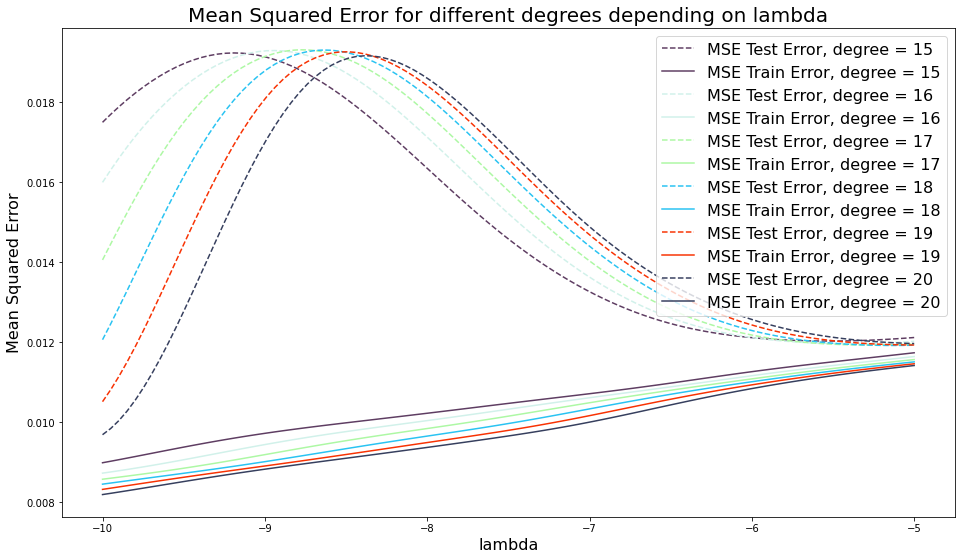

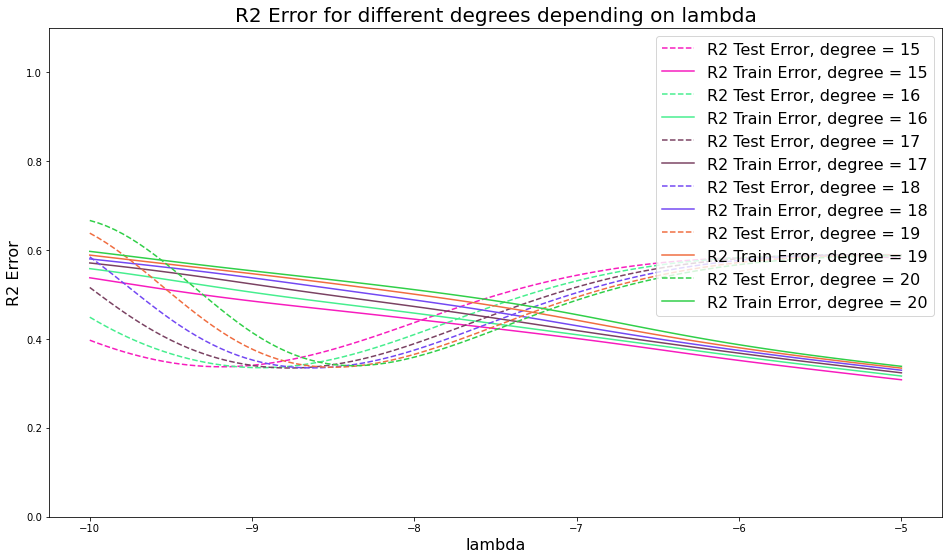

In [34]:
lambdas = np.logspace(-10,-5, 100)
DegreeStart = 18

MSETrainAllLambdas = []
MSETestAllLambdas = []
R2TrainAllLambdas = []
R2TestAllLambdas = []

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

for degree in range(DegreeStart, PolynomialDegree+1):
    PolyDegree = []

    MSETrain = []
    MSETest = []

    R2Train = []
    R2Test = []
    
    for lamb in lambdas:
        c, Xtilde = c_tilde(degree, x_train)
        model = Ridge(alpha = lamb)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain.append(mean_squared_error(ztilde,z_train))
        MSETest.append(mean_squared_error(z_test, z_pred))
        R2Train.append(r2_score(ztilde, z_train))
        R2Test.append(r2_score(z_test, z_pred))
        PolyDegree.append(degree)

    MSETrainAllLambdas.append(MSETrain)
    MSETestAllLambdas.append(MSETest)
    R2TrainAllLambdas.append(R2Train)
    R2TestAllLambdas.append(R2Test)

plt.figure(figsize=(16,9))
for i in range(0, len(MSETrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), MSETestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'MSE Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), MSETrainAllLambdas[i], color = "#" + color, label=f'MSE Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda", fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.title(f"Mean Squared Error for different degrees depending on lambda", fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

plt.figure(figsize=(16,9))
for i in range(0, len(R2TrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), R2TestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'R2 Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), R2TrainAllLambdas[i], color = "#" + color, label=f'R2 Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda", fontsize = 16)
plt.ylabel("R2 Error", fontsize = 16)
plt.ylim(0,1.1)
plt.title(f"R2 Error for different degrees depending on lambda", fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

/home/yamato/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.031e+01, tolerance: 4.647e-03
  model = cd_fast.enet_coordinate_descent(
/home/yamato/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.031e+01, tolerance: 4.647e-03
  model = cd_fast.enet_coordinate_descent(
/home/yamato/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

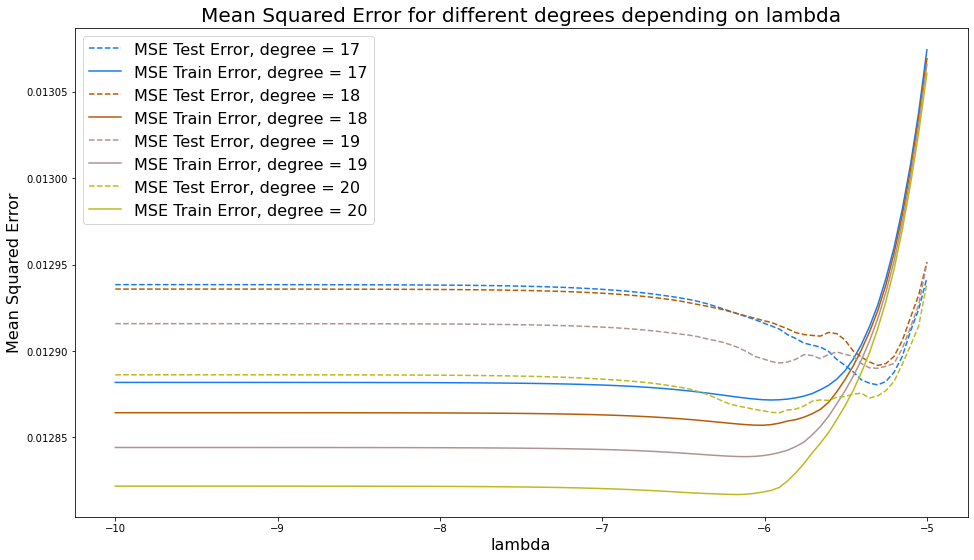

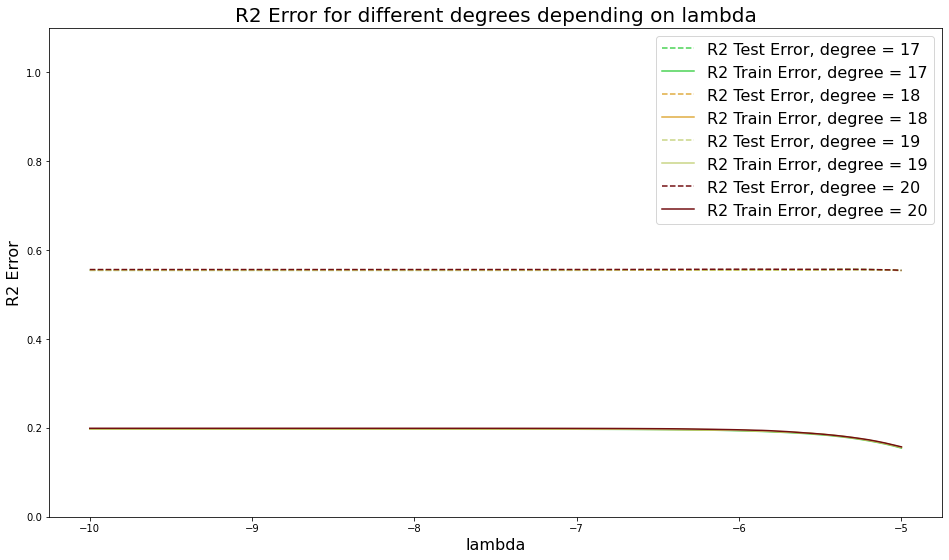

In [36]:
lambdas = np.logspace(-10,-5, 100)
DegreeStart = 18

MSETrainAllLambdas = []
MSETestAllLambdas = []
R2TrainAllLambdas = []
R2TestAllLambdas = []

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

for degree in range(DegreeStart, PolynomialDegree+1):
    PolyDegree = []

    MSETrain = []
    MSETest = []

    R2Train = []
    R2Test = []
    
    for lamb in lambdas:
        c, Xtilde = c_tilde(degree, x_train)
        model = Lasso(alpha = lamb)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain.append(mean_squared_error(ztilde,z_train))
        MSETest.append(mean_squared_error(z_test, z_pred))
        R2Train.append(r2_score(ztilde, z_train))
        R2Test.append(r2_score(z_test, z_pred))
        PolyDegree.append(degree)

    MSETrainAllLambdas.append(MSETrain)
    MSETestAllLambdas.append(MSETest)
    R2TrainAllLambdas.append(R2Train)
    R2TestAllLambdas.append(R2Test)

plt.figure(figsize=(16,9))
for i in range(0, len(MSETrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), MSETestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'MSE Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), MSETrainAllLambdas[i], color = "#" + color, label=f'MSE Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda", fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.title(f"Mean Squared Error for different degrees depending on lambda", fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

plt.figure(figsize=(16,9))
for i in range(0, len(R2TrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), R2TestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'R2 Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), R2TrainAllLambdas[i], color = "#" + color, label=f'R2 Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda", fontsize = 16)
plt.ylabel("R2 Error", fontsize = 16)
plt.ylim(0,1.1)
plt.title(f"R2 Error for different degrees depending on lambda", fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

Degree of polynomial:   1
Mean squared error on training data: 0.15352497
Mean squared error on test data: 0.15296767
Degree of polynomial:   2
Mean squared error on training data: 0.12751561
Mean squared error on test data: 0.12786318
Degree of polynomial:   3
Mean squared error on training data: 0.12458677
Mean squared error on test data: 0.12450078
Degree of polynomial:   4
Mean squared error on training data: 0.12457792
Mean squared error on test data: 0.12457792
Degree of polynomial:   5
Mean squared error on training data: 0.12434113
Mean squared error on test data: 0.12434113
Degree of polynomial:   6
Mean squared error on training data: 0.12396182
Mean squared error on test data: 0.12396182
Degree of polynomial:   7
Mean squared error on training data: 0.12418469
Mean squared error on test data: 0.12418469
Degree of polynomial:   8
Mean squared error on training data: 0.12405079
Mean squared error on test data: 0.12405079
Degree of polynomial:   9
Mean squared error on training

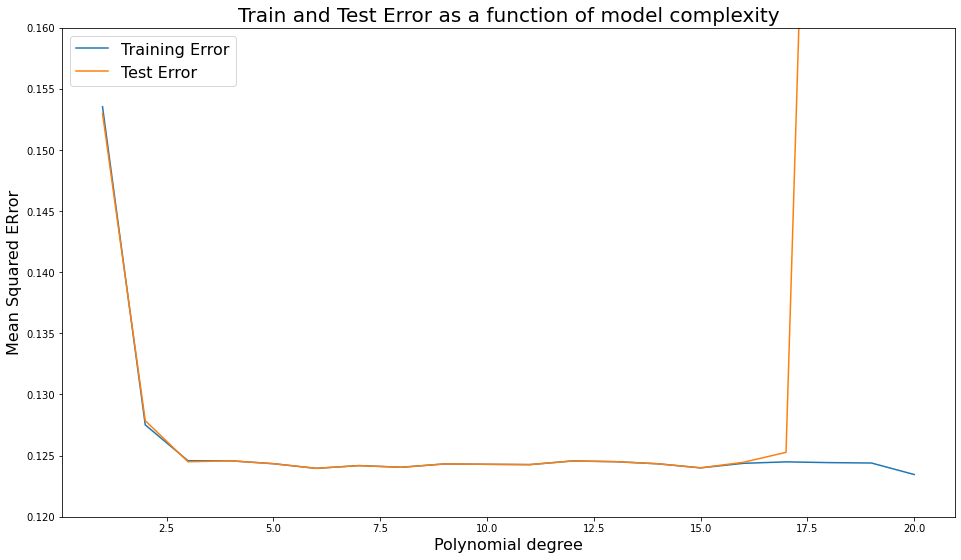

In [41]:

X = np.zeros((len(datapoints),PolynomialDegree))
X[:,0] = 1.0
testerror = np.zeros(PolynomialDegree)
trainingerror = np.zeros(PolynomialDegree)
polynomial = np.zeros(PolynomialDegree)

trials = 100
for polydegree in range(1, PolynomialDegree + 1):
    polynomial[polydegree - 1] = polydegree
    for degree in range(polydegree):
        X[:,degree] = z[:,0]**(degree/3.0)

# loop over trials in order to estimate the expectation value of the MSE
    testerror[polydegree - 1] = 0.0
    trainingerror[polydegree - 1] = 0.0
    for samples in range(trials):
        X_train, X_test, z_train, z_tests = train_test_split(X, z, test_size=0.2)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model = LinearRegression(fit_intercept=False).fit(X_train_scaled, z_train)
        zpred = model.predict(X_train_scaled)
        ztilde = model.predict(X_test_scaled)
        testerror[polydegree - 1] += mean_squared_error(z_tests, ztilde)
        trainingerror[polydegree - 1] += mean_squared_error(z_train, zpred) 

    testerror[polydegree - 1] /= trials
    trainingerror[polydegree - 1] /= trials
    print("Degree of polynomial: %3d"% polynomial[polydegree - 1])
    print("Mean squared error on training data: %.8f" % trainingerror[polydegree - 1])
    print("Mean squared error on test data: %.8f" % testerror[polydegree - 1])

plt.figure(figsize=(16,9))
plt.plot(polynomial, trainingerror, label='Training Error')
plt.plot(polynomial, testerror, label='Test Error')
plt.xlabel('Polynomial degree',fontsize = 16)
plt.ylabel('Mean Squared ERror',fontsize = 16)
plt.ylim(0.12,0.16)
plt.title("Train and Test Error as a function of model complexity",fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

In [43]:
np.random.seed(4242)

n_boostraps = 100
maxdegree = 18
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for degree in range(1, maxdegree + 1):
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    z_test = z_test.reshape(-1,1)

    model = LinearRegression(fit_intercept=False)
    z_pred = np.empty((z_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, z_train)
        z_pred[:, i] = model.fit(x_, y_).predict(X_test).ravel()
    polydegree[degree - 1] = degree
    error[degree - 1] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[degree - 1] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree - 1] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

plt.figure(figsize=(16,9))
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel("Polynomial Degree", fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.title("Bias and Variance error as a function of model complexity", fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

ValueError: X has 20 features, but PolynomialFeatures is expecting 2 features as input.

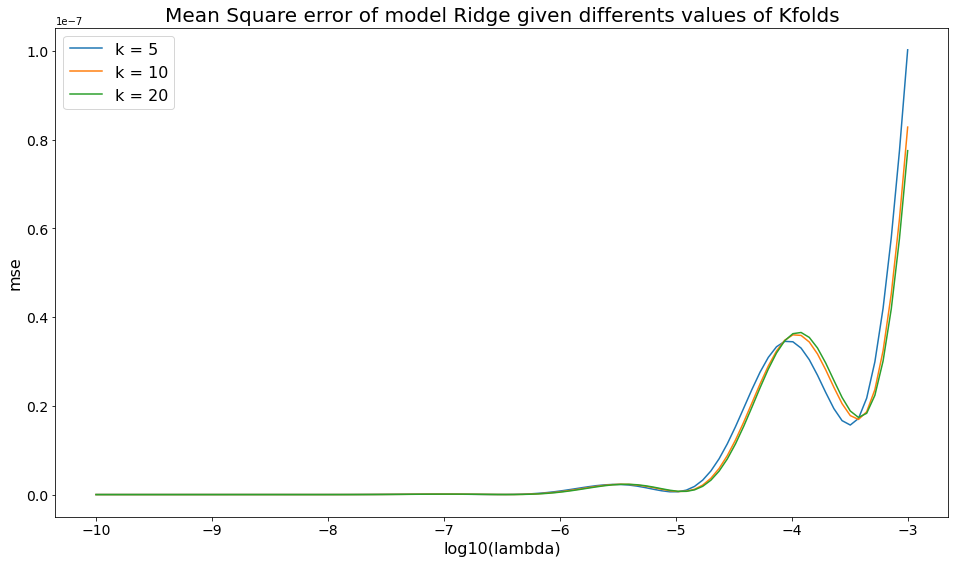

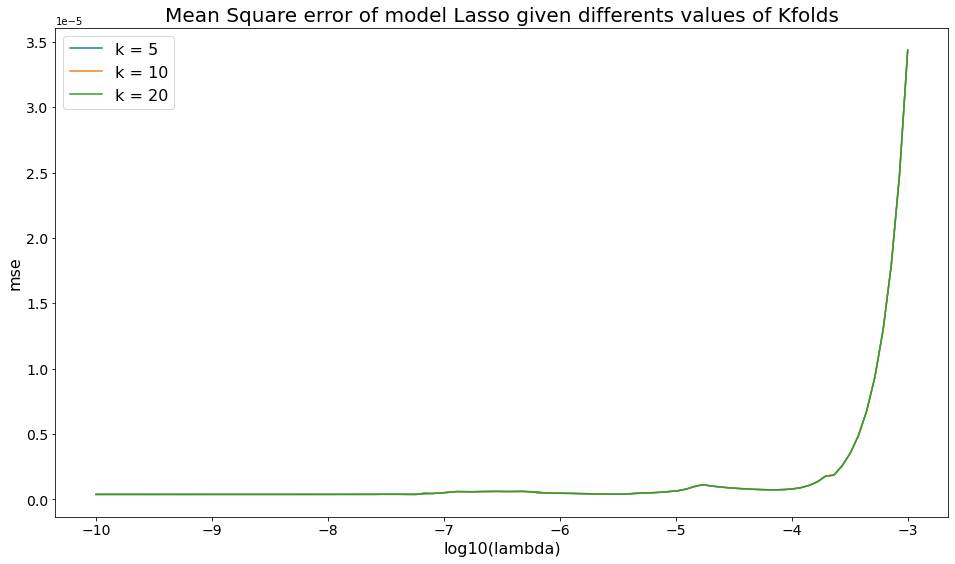

In [16]:
"""
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = degree)

# Decide which values of lambda to use
nlambdas = 50
lambdas = np.logspace(-4, 4, nlambdas)

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain = y[train_inds]

        xtest = x[test_inds]
        ytest = y[test_inds]

        print(xtrain.shape)

        Xtrain = poly.fit_transform(xtrain[:, 0])
        ridge.fit(Xtrain, ytrain[:, np.newaxis])

        Xtest = poly.fit_transform(xtest[:, np.newaxis])
        ypred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

        j += 1
    i += 1


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

## Cross-validation using cross_val_score from sklearn along with KFold

# kfold is an instance initialized above as:
# kfold = KFold(n_splits = k)

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    x = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, x, z[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation

plt.figure(figsize=(16,9))
plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()
"""

nlambdas = 100
lambdas = np.logspace(-10, -3, nlambdas)

mseOLS_5 = np.zeros(nlambdas)
mseOLS_10 = np.zeros(nlambdas)
mseOLS_20 = np.zeros(nlambdas)

mseRidge_5 = np.zeros(nlambdas)
mseRidge_10 = np.zeros(nlambdas)
mseRidge_20 = np.zeros(nlambdas)

mseLasso_5 = np.zeros(nlambdas)
mseLasso_10 = np.zeros(nlambdas)
mseLasso_20 = np.zeros(nlambdas)

k_dict_ols = {
        5: mseOLS_5,
        10: mseOLS_10,
        20: mseOLS_20
    }

k_dict_ridge = {
        5: mseRidge_5,
        10: mseRidge_10,
        20: mseRidge_20
    }

k_dict_lasso = {
        5: mseLasso_5,
        10: mseLasso_10,
        20: mseLasso_20
    }

z_train = z_train.ravel()

def k_fold_scikit(lambdas, k_dict, method):
    plt.figure(figsize=(16,9))
    for k, k_array in k_dict.items():
        kfold = KFold(n_splits = k)
        i = 0
        for lmbd in lambdas:
            match method:
                case "OLS":
                    model = LinearRegression(fit_intercept=True)
                case "Ridge":
                    model = Ridge(alpha=lmbd)
                case "Lasso":
                    model = Lasso(alpha=lmbd)
            mse_folds = cross_val_score(model, X_train, z_train[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)
            k_array[i] = np.mean(-mse_folds)
            i += 1
        plt.plot(np.log10(lambdas), k_array, label = f'k = {k}')
    plt.xlabel('log10(lambda)', fontsize = 16)
    plt.ylabel('mse', fontsize = 16)
    plt.xticks(fontsize=14)  
    plt.legend(fontsize=16)
    plt.yticks(fontsize=14)
    plt.title(f"Mean Square error of model {method} given differents values of Kfolds", fontsize=20)
    plt.show()

# k_fold_scikit(lambdas, k_dict_ols, "OLS")
k_fold_scikit(lambdas, k_dict_ridge, "Ridge")
k_fold_scikit(lambdas, k_dict_lasso, "Lasso")


